<a href="https://colab.research.google.com/github/abstractguy/crypto_bot/blob/master/crypto_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cryptocurrency trading bot.

Hardcoded parameters.

In [0]:
symbol = 'ETH-BTC'
period = '60m'
interval = '1m'

Installs.

In [2]:
!pip install python-binance yfinance --upgrade --no-cache-dir

Requirement already up-to-date: python-binance in /usr/local/lib/python3.6/dist-packages (0.7.5)
Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.54)


Library imports.

In [0]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.exceptions import BinanceAPIException
from time import sleep
from sys import exit

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf

Function definitions.

In [0]:
def fill_NANs(dataframe):
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)
    dataframe.iloc[0] = dataframe.iloc[1]
    return dataframe.fillna(axis='index', method='pad')

def heikin_ashi(df):
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['Open', 'High', 'Low', 'Close'])
    heikin_ashi_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['Open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

    heikin_ashi_df['High'] = heikin_ashi_df.loc[:, ['Open', 'Close']].join(df['High']).max(axis=1)
    heikin_ashi_df['Low'] = heikin_ashi_df.loc[:, ['Open', 'Close']].join(df['Low']).min(axis=1)

    return heikin_ashi_df

Download cryptocurrency symbol data.

In [5]:
dataset_downloaded = yf.download(tickers=[symbol], 
                                 period=period, 
                                 interval=interval, 
                                 group_by='ticker', 
                                 auto_adjust=True, 
                                 prepost=True)

dataset_downloaded = fill_NANs(dataset_downloaded)
dataset_downloaded

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Datetime,,,,,
2020-03-17 22:12:00+00:00,0.021705,0.021705,0.021705,0.021705,35528.0
2020-03-17 22:13:00+00:00,0.021705,0.021705,0.021705,0.021705,35528.0
2020-03-17 22:14:00+00:00,0.021710,0.021710,0.021710,0.021710,399.0
2020-03-17 22:15:00+00:00,0.021727,0.021727,0.021727,0.021727,1170.0
2020-03-17 22:16:00+00:00,0.021700,0.021700,0.021700,0.021700,0.0
2020-03-17 22:17:00+00:00,0.021690,0.021690,0.021690,0.021690,0.0
2020-03-17 22:18:00+00:00,0.021685,0.021685,0.021685,0.021685,0.0
2020-03-17 22:19:00+00:00,0.021705,0.021705,0.021705,0.021705,1801.0
2020-03-17 22:20:00+00:00,0.021702,0.021702,0.021702,0.021702,0.0


Download testing area -->

<-- End of download testing area.

*** To avoid downloading multiple times, restart here. ***

In [6]:
dataset = dataset_downloaded.copy()
dataset

,Open,High,Low,Close,Volume
Datetime,,,,,
2020-03-17 22:12:00+00:00,0.021705,0.021705,0.021705,0.021705,35528.0
2020-03-17 22:13:00+00:00,0.021705,0.021705,0.021705,0.021705,35528.0
2020-03-17 22:14:00+00:00,0.021710,0.021710,0.021710,0.021710,399.0
2020-03-17 22:15:00+00:00,0.021727,0.021727,0.021727,0.021727,1170.0
2020-03-17 22:16:00+00:00,0.021700,0.021700,0.021700,0.021700,0.0
2020-03-17 22:17:00+00:00,0.021690,0.021690,0.021690,0.021690,0.0
2020-03-17 22:18:00+00:00,0.021685,0.021685,0.021685,0.021685,0.0
2020-03-17 22:19:00+00:00,0.021705,0.021705,0.021705,0.021705,1801.0
2020-03-17 22:20:00+00:00,0.021702,0.021702,0.021702,0.021702,0.0


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



,Open,High,Low,Close
2020-03-17 22:12:00,0.0217046,0.021705,0.021705,0.021705
2020-03-17 22:13:00,0.0217046,0.021705,0.021705,0.021705
2020-03-17 22:14:00,0.0217046,0.021710,0.021705,0.021710
2020-03-17 22:15:00,0.0217075,0.021727,0.021707,0.021727
2020-03-17 22:16:00,0.0217171,0.021717,0.021700,0.021700
2020-03-17 22:17:00,0.0217087,0.021709,0.021690,0.021690
2020-03-17 22:18:00,0.0216993,0.021699,0.021685,0.021685
2020-03-17 22:19:00,0.0216922,0.021705,0.021692,0.021705
2020-03-17 22:20:00,0.0216983,0.021702,0.021698,0.021702
2020-03-17 22:21:00,0.0217,0.021710,0.021700,0.021710


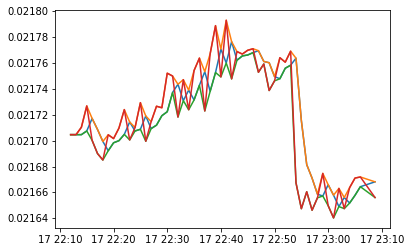

In [7]:
dataset = dataset.tz_localize(tz=None, ambiguous='infer')
heikin_ashi_dataset = heikin_ashi(dataset)
plt.plot(heikin_ashi_dataset)
heikin_ashi_dataset

In [8]:
fig = go.Figure(data=[go.Candlestick(x=heikin_ashi_dataset.index.to_series(), 
                                     open=heikin_ashi_dataset['Open'], 
                                     high=heikin_ashi_dataset['High'], 
                                     low=heikin_ashi_dataset['Low'], 
                                     close=heikin_ashi_dataset['Close'])])

fig.show()

2020-03-17 22:12:00    0
2020-03-17 22:13:00    0
2020-03-17 22:14:00    1
2020-03-17 22:15:00    1
2020-03-17 22:16:00    0
2020-03-17 22:17:00    0
2020-03-17 22:18:00    0
2020-03-17 22:19:00    1
2020-03-17 22:20:00    1
2020-03-17 22:21:00    1
2020-03-17 22:22:00    1
2020-03-17 22:23:00    0
2020-03-17 22:24:00    1
2020-03-17 22:25:00    1
2020-03-17 22:26:00    0
2020-03-17 22:27:00    1
2020-03-17 22:28:00    1
2020-03-17 22:29:00    1
2020-03-17 22:30:00    1
2020-03-17 22:31:00    1
2020-03-17 22:32:00    0
2020-03-17 22:33:00    1
2020-03-17 22:34:00    0
2020-03-17 22:35:00    1
2020-03-17 22:36:00    1
2020-03-17 22:37:00    0
2020-03-17 22:38:00    1
2020-03-17 22:39:00    1
2020-03-17 22:40:00    0
2020-03-17 22:41:00    1
2020-03-17 22:42:00    0
2020-03-17 22:43:00    1
2020-03-17 22:44:00    1
2020-03-17 22:45:00    1
2020-03-17 22:46:00    1
2020-03-17 22:47:00    0
2020-03-17 22:48:00    0
2020-03-17 22:49:00    0
2020-03-17 22:50:00    0
2020-03-17 22:51:00    1


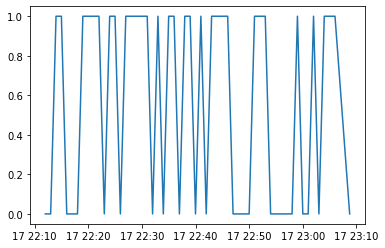

In [9]:
latent_trend = ((heikin_ashi_dataset['Close'] - heikin_ashi_dataset['Open']) > 0).astype(int)
plt.plot(latent_trend)
latent_trend

2020-03-17 22:12:00    1
2020-03-17 22:13:00    1
2020-03-17 22:14:00    1
2020-03-17 22:15:00    1
2020-03-17 22:16:00    0
2020-03-17 22:17:00    0
2020-03-17 22:18:00    0
2020-03-17 22:19:00    1
2020-03-17 22:20:00    1
2020-03-17 22:21:00    1
2020-03-17 22:22:00    1
2020-03-17 22:23:00    0
2020-03-17 22:24:00    1
2020-03-17 22:25:00    1
2020-03-17 22:26:00    0
2020-03-17 22:27:00    1
2020-03-17 22:28:00    1
2020-03-17 22:29:00    1
2020-03-17 22:30:00    1
2020-03-17 22:31:00    1
2020-03-17 22:32:00    0
2020-03-17 22:33:00    1
2020-03-17 22:34:00    0
2020-03-17 22:35:00    1
2020-03-17 22:36:00    1
2020-03-17 22:37:00    0
2020-03-17 22:38:00    1
2020-03-17 22:39:00    1
2020-03-17 22:40:00    0
2020-03-17 22:41:00    1
2020-03-17 22:42:00    0
2020-03-17 22:43:00    1
2020-03-17 22:44:00    1
2020-03-17 22:45:00    1
2020-03-17 22:46:00    1
2020-03-17 22:47:00    0
2020-03-17 22:48:00    0
2020-03-17 22:49:00    0
2020-03-17 22:50:00    0
2020-03-17 22:51:00    1


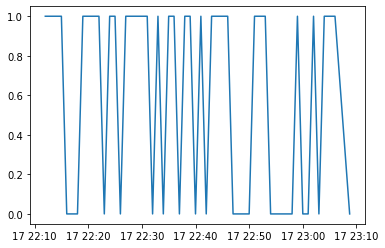

In [10]:
latest_trend = (heikin_ashi_dataset['High'] == heikin_ashi_dataset['Close']).astype(int)
plt.plot(latest_trend)
latest_trend

2020-03-17 22:12:00    0
2020-03-17 22:13:00    0
2020-03-17 22:14:00    1
2020-03-17 22:15:00    1
2020-03-17 22:16:00    0
2020-03-17 22:17:00    0
2020-03-17 22:18:00    0
2020-03-17 22:19:00    1
2020-03-17 22:20:00    1
2020-03-17 22:21:00    1
2020-03-17 22:22:00    1
2020-03-17 22:23:00    0
2020-03-17 22:24:00    1
2020-03-17 22:25:00    1
2020-03-17 22:26:00    0
2020-03-17 22:27:00    1
2020-03-17 22:28:00    1
2020-03-17 22:29:00    1
2020-03-17 22:30:00    1
2020-03-17 22:31:00    1
2020-03-17 22:32:00    0
2020-03-17 22:33:00    1
2020-03-17 22:34:00    0
2020-03-17 22:35:00    1
2020-03-17 22:36:00    1
2020-03-17 22:37:00    0
2020-03-17 22:38:00    1
2020-03-17 22:39:00    1
2020-03-17 22:40:00    0
2020-03-17 22:41:00    1
2020-03-17 22:42:00    0
2020-03-17 22:43:00    1
2020-03-17 22:44:00    1
2020-03-17 22:45:00    1
2020-03-17 22:46:00    1
2020-03-17 22:47:00    0
2020-03-17 22:48:00    0
2020-03-17 22:49:00    0
2020-03-17 22:50:00    0
2020-03-17 22:51:00    1


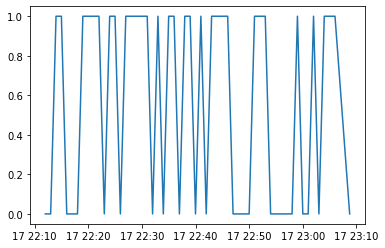

In [11]:
buy_position = latent_trend & latest_trend
plt.plot(buy_position)
buy_position

In [0]:
api_key = 'yoyoyo'
api_secret = 'yeyeye'

In [0]:
client = Client(api_key, api_secret)

In [15]:
price = client.get_historical_klines(symbol='BTCUSDT', 
                                     interval='1m', 
                                     start_str='15 minutes ago UTC')

price = pd.DataFrame(price, columns=['time', 
                                     'Open', 
                                     'High', 
                                     'Low', 
                                     'Close', 
                                     'Volume', 
                                     'Close time', 
                                     'Quote asset volume', 
                                     'Number of trades', 
                                     'Taker buy base asset volume', 
                                     'Taker buy quote asset volume', 
                                     'Ignore'])

price['time'] = \
    price['time'].apply(lambda x: \
                        datetime.datetime.fromtimestamp((x / 1000) - 14400))

price = price[['time', 
               'Open', 
               'High', 
               'Low', 
               'Close', 
               'Volume', 
               'Number of trades']]

price.set_index('time', inplace=True)
price

,Open,High,Low,Close,Volume,Number of trades
time,,,,,,
2020-03-17 18:56:00,5438.10000000,5440.46000000,5435.00000000,5439.77000000,20.83925100,261
2020-03-17 18:57:00,5440.46000000,5445.00000000,5439.94000000,5444.00000000,78.65696700,338
2020-03-17 18:58:00,5444.84000000,5450.00000000,5427.44000000,5431.79000000,120.39483300,771
2020-03-17 18:59:00,5429.09000000,5435.14000000,5421.46000000,5424.75000000,71.87350400,387
2020-03-17 19:00:00,5423.72000000,5427.23000000,5409.54000000,5420.41000000,67.95940100,517
2020-03-17 19:01:00,5420.41000000,5421.42000000,5410.73000000,5418.38000000,54.32432200,491
2020-03-17 19:02:00,5417.93000000,5419.64000000,5411.71000000,5419.63000000,47.29716800,269
2020-03-17 19:03:00,5419.12000000,5419.99000000,5411.14000000,5412.79000000,26.62748700,262
2020-03-17 19:04:00,5413.98000000,5415.76000000,5402.00000000,5406.64000000,39.27202400,378
